# Final Capstone Project

## *"Analysis of Resturants located in Georgia"*

*By Daniel Gould*

#### Introduction:

> While traveling in the southern states of the United States (specfically in Georgia), it has been identified by the client that it can be difficult to locate restuarants that meet a specific person's tastes/needs.
This capstone project will focus on the state of Georgia, analyzing the various categories of restaurants and food options available for travelers and localities in the different towns and cities. 

> During this exercise we will be aiming to use the data to address the following key questions:
> 1. What categories of restaurants are most popular across the different parts of Georgia?
> 2. Are there any vegan/vegetarian options available in Georgia? If so, where are they located?
> 3. Where can someone find a cafe or quick bite? (by this we mean fastfood)
> 4. Are there any restuarants that are based around southern cuisine? If so, Where are they located?
> 5. Which towns do not have dine-in restaurants?


#### Data Sources:
> 1. List of all towns and cities in Georgia, USASource: https://en.wikipedia.org/wiki/List_of_municipalities_in_Georgia_(U.S._state) 
> 2. Geolocation (latitude and longitude) of each town and city - Using Geocoder Nominatim OSM APIPackage: geocoder Nominatim 
> 3. Restaurants and food venues - From Foursquare crowdsource data, using ‘Venues’ endpointEndpoint: Foursquare venue explore endpoint https://api.foursquare.com/v2/venues/explore 



***

> #### Input required libraries for this exercise

In [2]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install geocoder
import geocoder # import geocoder

import seaborn as sns
import matplotlib.pyplot as plt

!pip install tensorflow

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
    100% |████████████████████████████████| 92kB 16.4MB/s ta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
    100% |████████████████████████████████| 102kB 17.9MB/s a 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
    100% |████████████████████████████████| 1.6MB 15.1MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 21.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 0.999999999
    Uninstalling html5lib-0.999999999:
      Successfully uninstalled html5lib-0.999999999
  Found existing installation: bleach 2.0.0
    Uninstalling bleach-2.0.0:
      Successfully uninstalled bleach-2.0.0


# 1. Build Data Frame

> Fetch the required data for this exercise. In this instance we require the List of municipalities in Georgia, United States. 

In [6]:
# Data source for the scrape is the wiki url
WIKI_URL="https://en.wikipedia.org/wiki/List_of_municipalities_in_Georgia_(U.S._state)"

# Pull data from the source url in xml format
req = requests.get(WIKI_URL)
soup = BeautifulSoup(req.content, 'lxml')

# Scrape the table data from the Wiki source required for this project
tables = soup.find("table", class_="wikitable sortable")

# Create an empty dataframe with a column to hold towm/ciry names
col_names =  ['Name']
df  = pd.DataFrame(columns = col_names)


# Parse the sortable table data from source, search for tr and td tags, and load the table data into the pandas dataframe
for tr in tables.find_all('tr'):
   tds = tr.find_all('td')
   if not tds:
      continue
   Name = [td.text.strip()+', GA' for td in tds[:1]]
   if "Total, GA" in Name:
      continue
   df.loc[len(df)] = Name

df.shape

(539, 1)

In [7]:
import re
for index, row in df.iterrows():
   row['Name'] = re.sub("[\(\[].*?[\)\]]", "", row['Name'])

df.head()

,Name
0,"Abbeville, GA"
1,"Acworth, GA"
2,"Adairsville, GA"
3,"Adel, GA"
4,"Adrian, GA"


> #### Now to fetch the geoloaction (Latitued & Longitude) for all of the cites and towns

In [8]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ga_explorer")
df['latitude']=""
df['longitude']=""

for index, row in df.iterrows():
   address = row['Name']
   location = geolocator.geocode(address)
   row['latitude'] = location.latitude
   row['longitude'] = location.longitude

df.shape

(539, 3)

In [9]:
df.to_csv('gacities_ll.csv',index=False)

In [10]:
df1 = pd.read_csv('gacities_ll.csv')
df1.shape

(539, 3)

In [11]:
df1.head()

,Name,latitude,longitude
0,"Abbeville, GA",31.992122,-83.306824
1,"Acworth, GA",34.065933,-84.676880
2,"Adairsville, GA",34.368702,-84.934109
3,"Adel, GA",31.137136,-83.423494
4,"Adrian, GA",32.530722,-82.589299


In [12]:
df = df1
del(df1)

> #### Now install the map rendering Library if you have not already done so

In [29]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



> #### Now we will creat a map of Georgia utilising the Latitude and Logitude values

In [13]:
address = 'Georgia, USA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Georgia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Georgia are 32.3293809, -83.1137366.


> #### Now we will create a map of Georgia using the latitiude and Logitude values

In [14]:
# create map of Georgia using latitude and longitude values
map_georgia = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(df['latitude'], df['longitude'], df['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia)  
    
map_georgia



#### Utilising Foursquare Location API, fetch Nearby Locations

> Initializing the basic Foursquare API parameters and Fetching Nearby Venues in the neighborhood Please apply your own FourSquare API Credentials here:

In [15]:
CLIENT_ID = 'CRT2REPOVNZMNWPELDULPNH1YCIVIWXG0WZWA34MKGABCLSE'
CLIENT_SECRET = 'DQ0W3FK32HPO1HBHSNZGTBDFY5K3DH2ELDFPTFS3QD3GG3SF'
VERSION = '20190518'

# Use foursquare and get top N velues for each toronto borough neighborhood
# Setting radius of 100,  and limiting no of venues to 50
LIMIT = 100 # limit of number of venues returned by Foursquare API
rad = 5000 # define radius
section = 'Food'

def getNearbyVenues(names, latitudes, longitudes, radius=rad):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
ga_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

In [17]:
print(ga_venues.shape)
ga_venues.head()

(13124, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Abbeville, GA",31.992122,-83.306824,Ophelias,31.992405,-83.306903,Diner
1,"Abbeville, GA",31.992122,-83.306824,Country Kitchen,31.992640,-83.307734,Food
2,"Abbeville, GA",31.992122,-83.306824,Mr B-b-q,31.993763,-83.295976,Food
3,"Acworth, GA",34.065933,-84.676880,Henry's Louisiana Grill,34.066011,-84.677728,Cajun / Creole Restaurant
4,"Acworth, GA",34.065933,-84.676880,Fusco's via Roma,34.065781,-84.677163,Italian Restaurant


In [18]:
ga_venues.to_csv('gavenues.csv',index=False)

In [19]:
import pandas as pd
ga1 = pd.read_csv('gavenues.csv')
ga1.shape

(13124, 7)

In [20]:
print("There are a total of {} venues, and the total distinct venue categories is {}".format(ga1.shape[0], ga1["Venue Category"].nunique()))

There are a total of 13124 venues, and the total distinct venue categories is 102


In [21]:
ga1.head(50)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Abbeville, GA",31.992122,-83.306824,Ophelias,31.992405,-83.306903,Diner
1,"Abbeville, GA",31.992122,-83.306824,Country Kitchen,31.992640,-83.307734,Food
2,"Abbeville, GA",31.992122,-83.306824,Mr B-b-q,31.993763,-83.295976,Food
3,"Acworth, GA",34.065933,-84.676880,Henry's Louisiana Grill,34.066011,-84.677728,Cajun / Creole Restaurant
4,"Acworth, GA",34.065933,-84.676880,Fusco's via Roma,34.065781,-84.677163,Italian Restaurant
5,"Acworth, GA",34.065933,-84.676880,Fish Thyme,34.050457,-84.663369,Seafood Restaurant
6,"Acworth, GA",34.065933,-84.676880,Bojangles' Famous Chicken 'n Biscuits,34.074136,-84.676541,Fast Food Restaurant
7,"Acworth, GA",34.065933,-84.676880,Miss L's Sandwich Shop,34.065861,-84.677276,Sandwich Place
8,"Acworth, GA",34.065933,-84.676880,Downtown Acworth,34.066043,-84.677738,American Restaurant
9,"Acworth, GA",34.065933,-84.676880,J.D.'s BBQ,34.062048,-84.665742,BBQ Joint


> #### Now we are going to add all of the restaurance into the same venu category

In [22]:
# Mapping any of the south american restaurants into the same venue category of South American Restaurant
ga1.loc[ga1['Venue Category'] == "Colombian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Argentinian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Brazilian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Peruvian Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Latin American Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Arepa Restaurant", 'Venue Category'] = "South American Restaurant"
ga1.loc[ga1['Venue Category'] == "Venezuelan Restaurant", 'Venue Category'] = "South American Restaurant"

# Mapping any of the american restaurants into the same venue category of American Restaurant
ga1.loc[ga1['Venue Category'] == "New American Restaurant", 'Venue Category'] = "American Restaurant"
ga1.loc[ga1['Venue Category'] == "Theme Restaurant", 'Venue Category'] = "American Restaurant"

# Mapping any of the chinese restaurants into the same venue category of Chinese Restaurant
ga1.loc[(ga1['Venue Category'] == "Asian Restaurant") & (ga1['Venue'].str.contains('chin', na=False) & ~ga1['Venue'].str.contains('japan', na=False)), 'Venue Category'] = "Chinese Restaurant"
ga1.loc[(ga1['Venue Category'] == "Food") & (ga1['Venue'].str.contains('chin')), 'Venue Category'] = "Chinese Restaurant"
ga1.loc[ga1['Venue Category'] == "Indian Chinese Restaurant", 'Venue Category'] = "Chinese Restaurant"

# Mapping any of the japanese restaurants into the same venue category of Japanese Restaurant
ga1.loc[(ga1['Venue Category'] == "Asian Restaurant") & (ga1['Venue'].str.contains('japan', na=False) & ~ga1['Venue'].str.contains('chin', na=False)), 'Venue Category'] = "Japanese Restaurant"
ga1.loc[(ga1['Venue Category'] == "Food") & (ga1['Venue'].str.contains('jap')), 'Venue Category'] = "Japanese Restaurant"

# Mapping any of the indian restaurants into the same venue category of Indian Restaurant
ga1.loc[ga1['Venue Category'] == "South Indian Restaurant", 'Venue Category'] = "Indian Restaurant"
ga1.loc[ga1['Venue Category'] == "North Indian Restanrant", 'Venue Category'] = "Indian Restaurant"
ga1.loc[ga1['Venue Category'] == "Chaat Place", 'Venue Category'] = "Indian Restaurant"

# Mapping any of the mex restaurants into the same venue category of Mexican Restaurant
ga1.loc[ga1['Venue Category'] == "Taco Place", 'Venue Category'] = "Mexican Restaurant"
ga1.loc[ga1['Venue Category'] == "Burrito Place", 'Venue Category'] = "Mexican Restaurant"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('mex')), 'Venue Category'] = "Mexican Restaurant"

# Mapping any of the pizza restaurants into the same venue category of Pizza Place
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('pizz')), 'Venue Category'] = "Pizza Place"

# Mapping any of the sub restaurants into the same venue category of Sandwich Place
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('sub')), 'Venue Category'] = "Sandwich Place"

# Mapping any of the mid eastern restaurants into the same venue category of Mediterranean Restaurant
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('Zoe')), 'Venue Category'] = "Mediterranean Restaurant"
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('med')), 'Venue Category'] = "Mediterranean Restaurant"
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('pita')), 'Venue Category'] = "Mediterranean Restaurant"
ga1.loc[ga1['Venue Category'] == "Falafel Restaurant", 'Venue Category'] = "Mediterranean Restaurant"

# Mapping any of the wing food place into the same venue category of Wings Joint
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('wing')), 'Venue Category'] = "Wings Joint"

# Mapping any of the chains into the same venue category of Fast Food Restaurant
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('Waffle House')), 'Venue Category'] = "Fast Food Restaurant"
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('Chick-fil-A')), 'Venue Category'] = "Fast Food Restaurant"
ga1.loc[(ga1['Venue Category'] == "Food") & (ga1['Venue'].str.contains('K F C')), 'Venue Category'] = "Fast Food Restaurant"

# Mapping any of the mongol restaurants into the same venue category of Mongolian Restaurant
ga1.loc[(ga1['Venue Category'] == "Restaurant") & (ga1['Venue'].str.contains('mongol')), 'Venue Category'] = "Mongolian Restaurant"

# Mapping any of the food stand/stop restaurants into the same venue category of Food Truck/Stand
ga1.loc[ga1['Venue Category'] == "Food Truck", 'Venue Category'] = "Food Truck/ Food Stand"
ga1.loc[ga1['Venue Category'] == "Food Stand", 'Venue Category'] = "Food Truck/ Food Stand"
ga1.loc[ga1['Venue Category'] == "Truck Stop", 'Venue Category'] = "Food Truck/ Food Stand"

# Mapping any of the cafe and coffee types into the same venue category of Cafe
ga1.loc[ga1['Venue Category'] == "Pet Café", 'Venue Category'] = "Café"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('cafe')), 'Venue Category'] = "Café"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('coffee')), 'Venue Category'] = "Café"

# Mapping any of the food court/cafeteria restaurants into the same venue category of Cafeteria/Food Court
ga1.loc[ga1['Venue Category'] == "Food Court", 'Venue Category'] = "Cafeteria/ Food Court"
ga1.loc[ga1['Venue Category'] == "Cafeteria", 'Venue Category'] = "Cafeteria/ Food Court"

# Mapping any of the breakfast type restaurants into the same venue category of Breakfast Spot/ Bagel Shop
ga1.loc[ga1['Venue Category'] == "Breakfast Spot", 'Venue Category'] = "Breakfast Spot/ Bagel Shop"
ga1.loc[ga1['Venue Category'] == "Bagel Shop", 'Venue Category'] = "Breakfast Spot/ Bagel Shop"

# Mapping any of the steakhouse restaurant/food into the same venue category of Steakhouse:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('Steakhouse')), 'Venue Category'] = "Steakhouse"

# Mapping any of the bbq restaurant/food into the same venue category of BBQ Joint:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('B-')), 'Venue Category'] = "BBQ Joint"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('bar')), 'Venue Category'] = "BBQ Joint"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('bar b')), 'Venue Category'] = "BBQ Joint"

# Mapping any of the sandwich restaurant/food into the same venue category of Sandwich Place:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('sandwich')), 'Venue Category'] = "Sandwich Place"
# Mapping any of the caribbean restaurants into the same venue category of Caribbean Restaurant
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('caribbean')), 'Venue Category'] = "Caribbean Restaurant"

# Mapping any of the diner food into the same venue category of Diner
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('diner')), 'Venue Category'] = "Diner"

# Mapping any of the snack food into the same venue category of Snack Place
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('snack')), 'Venue Category'] = "Snack Place"
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('Auntie Anne')), 'Venue Category'] = "Snack Place"

# Mapping any of the sea food into the same venue category of Seafood Restaurant:
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('fish')), 'Venue Category'] = "Seafood Restaurant"

# Mapping any of the bake food into the same venue category of Bakery
ga1.loc[(ga1['Venue Category'].isin(["Restaurant","Food"])) & (ga1['Venue'].str.contains('baker')), 'Venue Category'] = "Bakery"

# Mapping any of the mid eastern food into the same venue category of Mediterranean/Greek/Turkish Restaurant
ga1.loc[ga1['Venue Category'] == "Mediterranean Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"
ga1.loc[ga1['Venue Category'] == "Middle Eastern Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"
ga1.loc[ga1['Venue Category'] == "Greek Restaurant", 'Venue Category'] = "Mediterranean/reek/Turkish Restaurant"
ga1.loc[ga1['Venue Category'] == "Turkish Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"

In [23]:
ga1.loc[ga1['Venue Category'] == "Turkish Restaurant", 'Venue Category'] = "Mediterranean/Greek/Turkish Restaurant"
print('Total rows with cateogry = Food : ',ga1.loc[ga1['Venue Category'] == 'Food', 'Venue Category'].count())
print('Total rows with cateogry = Restaurant : ',ga1.loc[ga1['Venue Category'] == 'Restaurant', 'Venue Category'].count())
print('Total rows in final dataframe : ',ga1.shape[0])

Total rows with cateogry = Food :  359
Total rows with cateogry = Restaurant :  284
Total rows in final dataframe :  13124


> #### Now map all the remaining food venues and restaurant to 'Americal Restaurant'. This wil be default.

In [24]:
ga1.loc[ga1['Venue Category'] == "Food", 'Venue Category'] = "American Restaurant"
ga1.drop(ga1[ga1['Venue Category'] == "Food"].index, inplace=True)
ga1.drop(ga1[ga1['Venue Category'] == "Restaurant"].index, inplace=True)
ga1.reset_index(drop=True, inplace=True)
                      
ga1.loc[ga1['Venue Category'] == "Restaurant", 'Venue Category'] = "American Restaurant"

> #### We will now look at this in a table

In [25]:
ga_venues = ga1
ga_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Abbeville, GA",3,3,3,3,3,3
"Acworth, GA",98,98,98,98,98,98
"Adairsville, GA",21,21,21,21,21,21
"Adel, GA",24,24,24,24,24,24
"Adrian, GA",1,1,1,1,1,1
"Ailey, GA",4,4,4,4,4,4
"Alamo, GA",2,2,2,2,2,2
"Alapaha, GA",1,1,1,1,1,1
"Albany, GA",64,64,64,64,64,64


> #### We will now pull out the follow information:
> 1. Number of unique categories
> 2. Number of unique Neighborhoods
> 3. Number of venues broken down by category


In [26]:
print('There are {} unique categories.'.format(len(ga_venues['Venue Category'].unique())))
print('There are {} unique Neighborhoods.'.format(len(ga_venues['Neighborhood'].unique())))

There are 79 unique categories.
There are 468 unique Neighborhoods.


In [27]:
g1 = ga_venues.groupby(['Venue Category']).count()[['Venue']].sort_values('Venue', ascending=False).head(10)
g1

,Venue
Venue Category,
Fast Food Restaurant,1702
American Restaurant,1494
Pizza Place,1174
Sandwich Place,1033
Mexican Restaurant,1002
Fried Chicken Joint,550
Breakfast Spot/ Bagel Shop,532
Chinese Restaurant,498
BBQ Joint,450


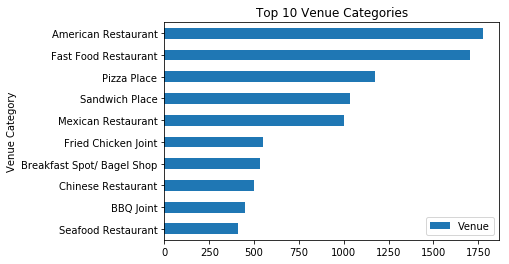

In [143]:
g1.sort_values('Venue',inplace=True)
g1.plot(kind='barh')
plt.title("Top 10 Venue Categories")
plt.show()

> #### Add neighborhood column back into dataframe.

In [28]:
# one hot encoding
ga_onehot = pd.get_dummies(ga_venues[['Venue Category']], prefix="", prefix_sep="")

ga_onehot['Neighborhood'] = ga_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ga_onehot.columns[-1]] + list(ga_onehot.columns[:-1])
ga_onehot = ga_onehot[fixed_columns]

ga_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Abbeville, GA",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Abbeville, GA",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Acworth, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Acworth, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
ga_onehot.shape

(12840, 80)

> #### Group rows by neighborhood, by taking the mean of the frequency of occurrence of each category.

In [30]:
ga_grouped = ga_onehot.groupby('Neighborhood').mean().reset_index()
ga_grouped

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0.00,0.333333,0.000000,0.00,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Acworth, GA",0.00,0.112245,0.000000,0.00,0.040816,0.030612,0.000000,0.040816,0.000000,...,0.010204,0.020408,0.0,0.0,0.000000,0.010204,0.010204,0.000000,0.000000,0.010204
2,"Adairsville, GA",0.00,0.095238,0.095238,0.00,0.000000,0.000000,0.000000,0.047619,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619
3,"Adel, GA",0.00,0.125000,0.000000,0.00,0.041667,0.000000,0.000000,0.083333,0.000000,...,0.041667,0.000000,0.0,0.0,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000
4,"Adrian, GA",0.00,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Ailey, GA",0.00,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Alamo, GA",0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Alapaha, GA",0.00,1.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Albany, GA",0.00,0.171875,0.000000,0.00,0.046875,0.031250,0.000000,0.015625,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
9,"Aldora, GA",0.05,0.150000,0.000000,0.00,0.100000,0.000000,0.000000,0.050000,0.000000,...,0.050000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [148]:
print(ga_grouped.shape)
ga_grouped.head()

(471, 80)


,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0.0,0.333333,0.000000,0.0,0.333333,0.00,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000
1,"Acworth, GA",0.0,0.130000,0.000000,0.0,0.040000,0.03,0.0,0.040000,0.0,...,0.010000,0.02,0.0,0.0,0.0,0.010000,0.01,0.0,0.0,0.010000
2,"Adairsville, GA",0.0,0.095238,0.095238,0.0,0.000000,0.00,0.0,0.047619,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.047619
3,"Adel, GA",0.0,0.125000,0.000000,0.0,0.041667,0.00,0.0,0.083333,0.0,...,0.041667,0.00,0.0,0.0,0.0,0.041667,0.00,0.0,0.0,0.000000
4,"Adrian, GA",0.0,0.000000,0.000000,0.0,0.000000,1.00,0.0,0.000000,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000


In [31]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

> #### We will not display the top 10 venues for 50 neighborhoods. 

In [32]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ga_grouped['Neighborhood']

for ind in np.arange(ga_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ga_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(50)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"Acworth, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,Chinese Restaurant,Seafood Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant,BBQ Joint
2,"Adairsville, GA",Fast Food Restaurant,Burger Joint,American Restaurant,Asian Restaurant,Mexican Restaurant,Fried Chicken Joint,Wings Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",Fast Food Restaurant,Pizza Place,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Breakfast Spot/ Bagel Shop,Steakhouse,Japanese Restaurant,Chinese Restaurant,Sandwich Place
4,"Adrian, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
5,"Ailey, GA",Chinese Restaurant,American Restaurant,Sandwich Place,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
6,"Alamo, GA",Burger Joint,Café,Donut Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
7,"Alapaha, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
8,"Albany, GA",Fast Food Restaurant,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Wings Joint,Hot Dog Joint,Bakery,Italian Restaurant
9,"Aldora, GA",Pizza Place,American Restaurant,Fast Food Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Café


> #### Clustering

In [33]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

ga_grouped_clustering = ga_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ga_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([8, 0, 0, 0, 5, 7, 6, 2, 0, 0, 0, 1, 0, 3, 1, 8, 0, 1, 2, 0], dtype=int32)

> #### Now we will create a new dataframe that include the cluster as well as the top 10 venues for each neighborhood

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ga_merged = df

# merge ga_grouped with ga_data to add latitude/longitude for each neighborhood
ga_merged = ga_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

ga_merged.head() # check the last columns!

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",31.992122,-83.306824,8.0,Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"Acworth, GA",34.065933,-84.676880,0.0,Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,Chinese Restaurant,Seafood Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant,BBQ Joint
2,"Adairsville, GA",34.368702,-84.934109,0.0,Fast Food Restaurant,Burger Joint,American Restaurant,Asian Restaurant,Mexican Restaurant,Fried Chicken Joint,Wings Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",31.137136,-83.423494,0.0,Fast Food Restaurant,Pizza Place,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Breakfast Spot/ Bagel Shop,Steakhouse,Japanese Restaurant,Chinese Restaurant,Sandwich Place
4,"Adrian, GA",32.530722,-82.589299,5.0,Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


In [36]:
ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])].shape[0]

71

In [37]:
ga_merged.dropna(inplace=True)

In [38]:
ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])]

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [39]:
ga_merged['Cluster Labels'] = ga_merged['Cluster Labels'].apply(lambda x: int(x) if x == x else 0)
ga_merged.head(50)

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",31.992122,-83.306824,8,Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
1,"Acworth, GA",34.065933,-84.676880,0,Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,Chinese Restaurant,Seafood Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant,BBQ Joint
2,"Adairsville, GA",34.368702,-84.934109,0,Fast Food Restaurant,Burger Joint,American Restaurant,Asian Restaurant,Mexican Restaurant,Fried Chicken Joint,Wings Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",31.137136,-83.423494,0,Fast Food Restaurant,Pizza Place,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Breakfast Spot/ Bagel Shop,Steakhouse,Japanese Restaurant,Chinese Restaurant,Sandwich Place
4,"Adrian, GA",32.530722,-82.589299,5,Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
5,"Ailey, GA",32.187404,-82.565689,7,Chinese Restaurant,American Restaurant,Sandwich Place,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
6,"Alamo, GA",32.147120,-82.777917,6,Burger Joint,Café,Donut Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
7,"Alapaha, GA",31.385195,-83.222932,2,American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
8,"Albany, GA",31.578206,-84.155681,0,Fast Food Restaurant,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Wings Joint,Hot Dog Joint,Bakery,Italian Restaurant
9,"Aldora, GA",33.052071,-84.175750,0,Pizza Place,American Restaurant,Fast Food Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Café


> #### Now we are going to create out map based on the above clusters

In [40]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ga_merged['latitude'], ga_merged['longitude'], ga_merged['Name'], ga_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

> #### Cluster 1

In [41]:
ga_merged.loc[ga_merged['Cluster Labels'] == 0, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Acworth, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,Chinese Restaurant,Seafood Restaurant,Breakfast Spot/ Bagel Shop,Italian Restaurant,BBQ Joint
2,"Adairsville, GA",Fast Food Restaurant,Burger Joint,American Restaurant,Asian Restaurant,Mexican Restaurant,Fried Chicken Joint,Wings Joint,Pizza Place,Sandwich Place,Japanese Restaurant
3,"Adel, GA",Fast Food Restaurant,Pizza Place,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Breakfast Spot/ Bagel Shop,Steakhouse,Japanese Restaurant,Chinese Restaurant,Sandwich Place
8,"Albany, GA",Fast Food Restaurant,American Restaurant,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Wings Joint,Hot Dog Joint,Bakery,Italian Restaurant
9,"Aldora, GA",Pizza Place,American Restaurant,Fast Food Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Café
10,"Allenhurst, GA",Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Breakfast Spot/ Bagel Shop,Seafood Restaurant,Korean Restaurant,Steakhouse,Donut Shop,Fondue Restaurant
12,"Alma, GA",Pizza Place,Fast Food Restaurant,Wings Joint,Fried Chicken Joint,Sandwich Place,Buffet,Diner,BBQ Joint,American Restaurant,Gastropub
17,"Americus, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Mexican Restaurant,Fried Chicken Joint,Sandwich Place,Southern / Soul Food Restaurant,Seafood Restaurant,Japanese Restaurant,Cafeteria/ Food Court
20,"Aragon, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Fried Chicken Joint,Mexican Restaurant,Breakfast Spot/ Bagel Shop,Southern / Soul Food Restaurant,Japanese Restaurant,Sandwich Place,Wings Joint
30,"Augusta, GA",Fast Food Restaurant,American Restaurant,Sandwich Place,Fried Chicken Joint,Mexican Restaurant,Pizza Place,Italian Restaurant,Burger Joint,Japanese Restaurant,BBQ Joint


> #### Cluster 2

In [42]:
ga_merged.loc[ga_merged['Cluster Labels'] == 1, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Allentown, GA",American Restaurant,Fast Food Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant
14,"Alston, GA",American Restaurant,BBQ Joint,Fast Food Restaurant,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant
18,"Andersonville, GA",Burger Joint,American Restaurant,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
35,"Baconton, GA",American Restaurant,Breakfast Spot/ Bagel Shop,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
47,"Between, GA",American Restaurant,Diner,Japanese Restaurant,Fast Food Restaurant,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant
88,"Carnesville, GA",American Restaurant,Donut Shop,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
91,"Cave Spring, GA",American Restaurant,Mexican Restaurant,Steakhouse,Diner,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
111,"Cohutta, GA",American Restaurant,Food Truck/ Food Stand,BBQ Joint,Southern / Soul Food Restaurant,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
129,"Cusseta, GA",American Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Sandwich Place,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
152,"Doerun, GA",American Restaurant,Chinese Restaurant,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


> #### Cluster 3

In [43]:
ga_merged.loc[ga_merged['Cluster Labels'] == 2, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Alapaha, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
19,"Arabi, GA",American Restaurant,Australian Restaurant,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
23,"Arlington, GA",American Restaurant,Sandwich Place,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
54,"Bluffton, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
61,"Bowman, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
70,"Broxton, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
81,"Calhoun, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
98,"Chattahoochee Hills, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
121,"Coolidge, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
149,"De Soto, GA",American Restaurant,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


> #### Cluster 4

In [44]:
ga_merged.loc[ga_merged['Cluster Labels'] == 3, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,"Alpharetta, GA",American Restaurant,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Mediterranean/Greek/Turkish Restaurant,Italian Restaurant,Breakfast Spot/ Bagel Shop,Thai Restaurant,Café,Burger Joint
26,"Athens, GA",Mexican Restaurant,American Restaurant,Breakfast Spot/ Bagel Shop,Pizza Place,Sandwich Place,BBQ Joint,Fast Food Restaurant,Thai Restaurant,Fried Chicken Joint,Steakhouse
27,"Atlanta, GA",American Restaurant,Mexican Restaurant,Pizza Place,Seafood Restaurant,Breakfast Spot/ Bagel Shop,Caribbean Restaurant,Burger Joint,Mediterranean/Greek/Turkish Restaurant,Southern / Soul Food Restaurant,Deli / Bodega
34,"Avondale Estates, GA",Pizza Place,American Restaurant,Breakfast Spot/ Bagel Shop,Fast Food Restaurant,Indian Restaurant,Mexican Restaurant,Sushi Restaurant,Sandwich Place,Gastropub,South American Restaurant
38,"Ball Ground, GA",Donut Shop,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Wings Joint
44,"Berkeley Lake, GA",Mexican Restaurant,Sandwich Place,Korean Restaurant,Donut Shop,Pizza Place,Breakfast Spot/ Bagel Shop,Wings Joint,Indian Restaurant,American Restaurant,Chinese Restaurant
52,"Bloomingdale, GA",Pizza Place,Sandwich Place,Mexican Restaurant,Chinese Restaurant,Italian Restaurant,BBQ Joint,Japanese Restaurant,Burger Joint,Breakfast Spot/ Bagel Shop,Wings Joint
55,"Blythe, GA",Burger Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
59,"Bowdon, GA",Mexican Restaurant,Burger Joint,Sandwich Place,Fast Food Restaurant,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
67,"Brookhaven, GA",American Restaurant,Mexican Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Breakfast Spot/ Bagel Shop,Sandwich Place,Burger Joint,Mediterranean/Greek/Turkish Restaurant,Indian Restaurant


> #### Cluster 5

In [45]:
ga_merged.loc[ga_merged['Cluster Labels'] == 4, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Arcade, GA",Seafood Restaurant,Spanish Restaurant,Filipino Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
169,"Edge Hill, GA",Seafood Restaurant,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
316,"Midville, GA",Seafood Restaurant,BBQ Joint,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
381,"Pitts, GA",Diner,Seafood Restaurant,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
484,"Toomsboro, GA",Seafood Restaurant,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


> #### Cluster 6

In [46]:
ga_merged.loc[ga_merged['Cluster Labels'] == 5, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Adrian, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
45,"Berlin, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
66,"Bronwood, GA",Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


> #### Cluster 7

In [47]:
ga_merged.loc[ga_merged['Cluster Labels'] == 6, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Alamo, GA",Burger Joint,Café,Donut Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
57,"Boston, GA",Pizza Place,Café,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
84,"Canon, GA",Café,Spanish Restaurant,Diner,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
150,"Dexter, GA",Café,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
182,"Fargo, GA",American Restaurant,Café,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
204,"Gillsville, GA",Sandwich Place,Café,Wings Joint,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
215,"Greenville, GA",American Restaurant,Café,Diner,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
243,"Homer, GA",Café,Burger Joint,Portuguese Restaurant,Fast Food Restaurant,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Filipino Restaurant
383,"Plainville, GA",Burger Joint,Sandwich Place,Café,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
433,"Shady Dale, GA",Café,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


> #### Cluster 8

In [48]:
ga_merged.loc[ga_merged['Cluster Labels'] == 7, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Ailey, GA",Chinese Restaurant,American Restaurant,Sandwich Place,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
24,"Arnoldsville, GA",Diner,American Restaurant,Breakfast Spot/ Bagel Shop,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
25,"Ashburn, GA",American Restaurant,BBQ Joint,Fried Chicken Joint,Deli / Bodega,Pizza Place,Breakfast Spot/ Bagel Shop,Mexican Restaurant,Sandwich Place,Seafood Restaurant,Fast Food Restaurant
29,"Auburn, GA",American Restaurant,BBQ Joint,Fast Food Restaurant,Breakfast Spot/ Bagel Shop,Sandwich Place,Chinese Restaurant,Wings Joint,Fish & Chips Shop,Empanada Restaurant,English Restaurant
51,"Blakely, GA",American Restaurant,Fried Chicken Joint,Pizza Place,Diner,Fast Food Restaurant,Deli / Bodega,Sandwich Place,Mexican Restaurant,Café,Eastern European Restaurant
56,"Bogart, GA",American Restaurant,Pizza Place,BBQ Joint,Fried Chicken Joint,Breakfast Spot/ Bagel Shop,Mexican Restaurant,Fast Food Restaurant,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant
72,"Buchanan, GA",American Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Mexican Restaurant,Fast Food Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
76,"Butler, GA",Pizza Place,American Restaurant,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
83,"Camilla, GA",American Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Diner,Sandwich Place,Mexican Restaurant,Pizza Place,Food Truck/ Food Stand,Fondue Restaurant,Fish & Chips Shop
86,"Carl, GA",American Restaurant,Sandwich Place,Chinese Restaurant,Pizza Place,BBQ Joint,Breakfast Spot/ Bagel Shop,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Eastern European Restaurant


> #### Cluster 9

In [49]:
ga_merged.loc[ga_merged['Cluster Labels'] == 8, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",Diner,American Restaurant,BBQ Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
15,"Alto, GA",BBQ Joint,Spanish Restaurant,Sandwich Place,Diner,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
46,"Bethlehem, GA",Food Truck/ Food Stand,BBQ Joint,Breakfast Spot/ Bagel Shop,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
48,"Bishop, GA",Vegetarian / Vegan Restaurant,American Restaurant,BBQ Joint,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
60,"Bowersville, GA",American Restaurant,BBQ Joint,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
74,"Buena Vista, GA",BBQ Joint,Pizza Place,American Restaurant,Sandwich Place,Mexican Restaurant,Filipino Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
112,"Colbert, GA",Hot Dog Joint,BBQ Joint,Bakery,Seafood Restaurant,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
114,"Collins, GA",American Restaurant,BBQ Joint,Steakhouse,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
144,"Dearing, GA",American Restaurant,BBQ Joint,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
186,"Flovilla, GA",American Restaurant,BBQ Joint,Mexican Restaurant,Wings Joint,Fish & Chips Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant


> #### Cluster 10

In [50]:
ga_merged.loc[ga_merged['Cluster Labels'] == 9, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
205,"Girard, GA",Southern / Soul Food Restaurant,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
259,"Jersey, GA",Southern / Soul Food Restaurant,Malay Restaurant,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant
385,"Portal, GA",Southern / Soul Food Restaurant,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant


> #### No we are going to group the clusters

In [51]:
ga_grouped_clustering.head()

,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot/ Bagel Shop,Buffet,Burger Joint,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0.0,0.333333,0.000000,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,0.112245,0.000000,0.0,0.040816,0.030612,0.0,0.040816,0.0,0.020408,...,0.010204,0.020408,0.0,0.0,0.0,0.010204,0.010204,0.0,0.0,0.010204
2,0.0,0.095238,0.095238,0.0,0.000000,0.000000,0.0,0.047619,0.0,0.095238,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.047619
3,0.0,0.125000,0.000000,0.0,0.041667,0.000000,0.0,0.083333,0.0,0.000000,...,0.041667,0.000000,0.0,0.0,0.0,0.041667,0.000000,0.0,0.0,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000


> #### Now we are going to plot the information from the clusters

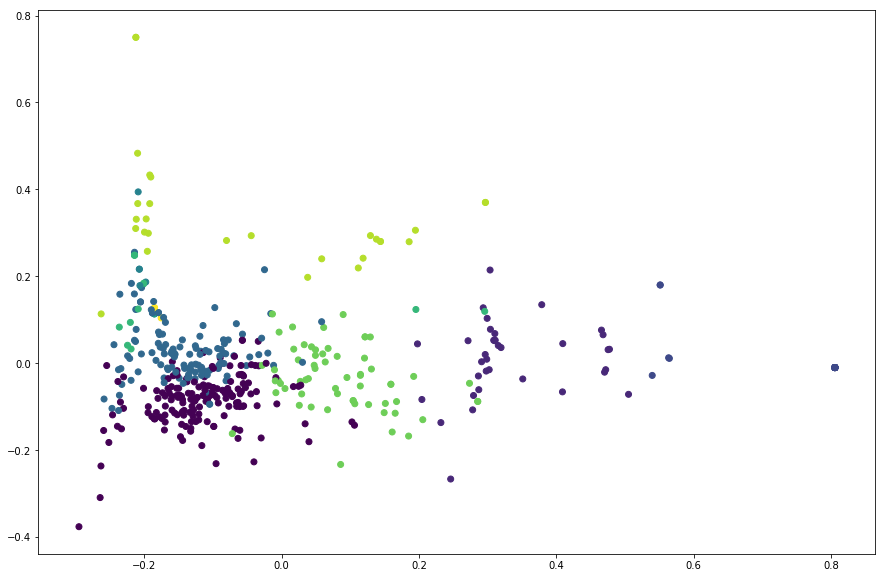

In [52]:
from sklearn.decomposition import PCA
import pylab as pl
%matplotlib inline
pca = PCA(n_components=2).fit(ga_grouped_clustering)
pca_2d = pca.transform(ga_grouped_clustering)
pl.figure('Scatter Plot')
pl.figure(figsize=(15, 10))
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, marker='o')
pl.show()

In [53]:
# Most common Vegetarian / Vegan Restaurant 
ga_merged[ga_merged['1st Most Common Venue'].str.contains('Veg')]

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Bishop, GA",33.819286,-83.438772,8,Vegetarian / Vegan Restaurant,American Restaurant,BBQ Joint,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant
351,"North High Shoals, GA",33.820120,-83.505997,8,Vegetarian / Vegan Restaurant,American Restaurant,BBQ Joint,Wings Joint,Fondue Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Fast Food Restaurant


In [54]:
ga_venues[ga_venues["Venue Category"].str.contains("Veg")].shape[0]

33

> #### create map of Georgia using latitude and longitude values

In [55]:
ga_veg = ga_venues[ga_venues["Venue Category"].str.contains("Veg")]

map_georgia_veg = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_veg['Venue Latitude'], ga_veg['Venue Longitude'], ga_veg['Venue']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_veg)  
    
map_georgia_veg

In [56]:
ga_cafe = ga_venues[ga_venues["Venue Category"].str.contains("Cafe")]

# create map of Georgia using latitude and longitude values
map_georgia_cafe = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_cafe['Venue Latitude'], ga_cafe['Venue Longitude'], ga_cafe['Venue']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_cafe)  
    
map_georgia_cafe

In [57]:
ga_southern = ga_venues[ga_venues["Venue Category"].str.contains("Southern")]

# create map of Georgia using latitude and longitude values
map_georgia_s = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_southern['Venue Latitude'], ga_southern['Venue Longitude'], ga_southern['Venue']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_s)  
    
map_georgia_s

In [62]:
ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])].head()

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [63]:
ga_none = ga_merged[pd.isnull(ga_merged['1st Most Common Venue'])]
# create map of Georgia using latitude and longitude values
map_georgia_none = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(ga_none['latitude'], ga_none['longitude'], ga_none['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia_none)  
    
map_georgia_none